<a href="https://colab.research.google.com/github/palienko105/Projects/blob/main/ABC_XYZ_analysis_PostgreSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение к БД:

In [2]:
!pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import psycopg2

In [5]:
con = psycopg2.connect(host="89.208.197.76", port = 5432, database="apteka", user="student", password="qweasd963")

In [6]:
cur = con.cursor()

In [7]:
def select (sql):
  return pd.read_sql(sql, con)

In [8]:
sql = '''
select * from information_schema.tables
'''
select (sql)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,apteka,public,cities,BASE TABLE,None,None,None,None,None,YES,NO,None
1,apteka,public,bonuscheques,BASE TABLE,None,None,None,None,None,YES,NO,None
2,apteka,public,discounts,BASE TABLE,None,None,None,None,None,YES,NO,None
3,apteka,public,employee,BASE TABLE,None,None,None,None,None,YES,NO,None
4,apteka,public,sales,BASE TABLE,None,None,None,None,None,YES,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...
193,apteka,information_schema,foreign_data_wrappers,VIEW,None,None,None,None,None,NO,NO,None
194,apteka,information_schema,foreign_server_options,VIEW,None,None,None,None,None,NO,NO,None
195,apteka,information_schema,foreign_servers,VIEW,None,None,None,None,None,NO,NO,None
196,apteka,information_schema,user_mappings,VIEW,None,None,None,None,None,NO,NO,None


# Задание:

Необходимо провести XYZ анализ ассортимента. Обычно XYZ анализ всегда проводится вместе с ABC анализом, поэтому нужно «дописать» этот запрос в запрос для проведения ABC.

Примечание: То есть для решения пункта 1 и пункта 2 у вас будет написан один SQL-запрос!

---



Примечание: ABC/XYZ-анализ должен быть представлен одним SQL-запросом.

Для расчетов вам понадобится таблица *sales*, а именно столбцы:

*dr_kol* - кол-во проданного товара в данной строке чека   
*dr_ndrugs* - название товара   
*dr_dat* - дата чека   
*dr_croz* - розничная цена   
*dr_czak* - закупочная цена   
*dr_sdisc* - сумма скидки на всю строку чека (даже если dr_kol > 1, вычитать сумму скидки нужно со строки чека, а не с каждой проданной позиции)   



---
В качестве периодов для расчета берите недельные продажи. Чтобы определить группу товара, должно быть минимум 4 продажи этого товара в разные недели.

Например, если товар продавался 7 раз, но все в период и 10 по 15 марта 2022 года, то расчитать XYZ-группу мы не можем. А если он продался 4 раза, но все продажи были сделаны в разные недели, то определить группу мы сможем.

Соответственно, если группу для данного товара определить не получилось, то в итоговой таблице там просто должен стоять NULL.

In [9]:
sql = '''
select pg_typeof(dr_dat) from sales limit 1
'''
select (sql)

,pg_typeof
0,date


In [31]:
sql = '''
select min(dr_dat) as mindt, max(dr_dat) as maxdt
from sales
'''
select (sql)

,mindt,maxdt
0,2022-05-01,2022-06-09


Продажи были с 2022-05-01 по 2022-06-09

# Решение:

**XYZ-анализ**



---
XYZ-анализ выделяет товары со стабильным спросом. Для этого рассчитывается, как меняется объём продаж от периода к периоду. По каждой товарной группе определяется коэффициент вариации, который показывает колебание спроса за отдельно взятый период:

* Х — товары со стабильным спросом. Колебание от 0−10%
* Y — середнячки, например, сезонные товары. Колебание 10−25%
* Z — товары со случайным спросом. Колебание от 25%

Коэффициент вариации рассчитывается по формуле koef = Стандартное отклонение выборки / Среднее значение выборки

Чем ближе коэффициент к нулю, тем стабильнее спрос — на такие товары стоит делать основной акцент в рекламе. Чем дальше коэффициент от нуля, тем сложнее предугадать купят товар или нет.

---




In [35]:
sql = '''
with xyz_t1 as -- сводная таблица с продажами товаров с разбивкой по неделям.
( 
select dr_ndrugs as product,extract(week from dr_dat) as week_num, sum(dr_kol) as kol_per_week
from sales
group by dr_ndrugs, extract(week from dr_dat)
),
xyz_t2 as -- Считаем коэффициент вариации и основываясь на его значении присваиваем категорию продукту.
(
select product,
case
  when stddev_samp(kol_per_week) / avg(kol_per_week) < 0.1 then 'X'
  when stddev_samp(kol_per_week) / avg(kol_per_week) < 0.25 then 'Y'
  else 'Z'
end as xyz_sales
from xyz_t1
group by product
having count(distinct week_num) >= 4
)

select * from xyz_t2
'''
select (sql)

,product,xyz_sales
0,"5 ДНЕЙ СР-ВО Д/НОГ ОТ ПОТА И ЗАПАХА 1,5Г. №10 ...",Z
1,911-БАДЯГА ГЕЛЬ Д/ТЕЛА ОТ СИНЯКОВ И УШИБОВ 100МЛ.,X
2,"911-ВЕНОЛГОН ГЕЛЬ Д/НОГ ПРИ ТЯЖЕСТИ,БОЛИ,ОТЕКА...",Z
3,911-ГЕЛЬ-БАЛЬЗАМ Д/СУСТАВОВ ПЧЕЛИНЫЙ ЯД 100МЛ.,Z
4,911-ГЕЛЬ-БАЛЬЗАМ Д/СУСТАВОВ САБЕЛЬНИК 100МЛ.,Z
...,...,...
1674,ЮНИДОКС СОЛЮТАБ 100МГ. №20 ТАБ.ДИСПЕРГ. /АСТЕЛ...,Z
1675,ЮНИЭНЗИМ С МПС №20 ТАБ. П/О,Z
1676,ЯНТАРНАЯ К-ТА 100МГ. №10 ТАБ. (БАД) /МАРБИОФАРМ/,Z
1677,ЯНТАРНАЯ К-ТА 100МГ. №20 ТАБ. (БАД),Z


In [36]:
sql = '''
select count(*) from sales
'''
select (sql)

,count
0,45128


**ABC-анализ**



---


Суть ABC анализа заключается в том, чтобы классифицировать позиции с точки зрения их вклада в общий "котел" выручки / количества / прибыли.

Обычно происходит разделение на 3 группы:

*   **Группа A** - наиболее ценные позиции, они обеспечивают 80% продаж.
*   **Группа B** - промежуточные позиции, они обеспечивают 15% продаж.
*   **Группа С** - наименее ценные позиции, они обеспечивают 5% продаж.

Алгоритм проведения ABC-анализа на примере продаж:

1. Считаем количество продаж каждого товара.
2. Сортируем таблицу по убыванию количества продаж.
3. Считаем накопительную сумму для каждого продукта.
4. Делим накопительную сумму для каждого товара на общую сумму всех продаж.
5. Основываясь на результате вычислений выше относим товар к той или иной группе.


---




In [37]:
sql = '''
-- PostgreSQL

with svod as -- Считаем Количество товара, Выручку и прибыль по каждому товару
(
  select dr_ndrugs as product, sum(dr_kol) as amount, 
  sum(dr_kol*(dr_croz - dr_czak) - dr_sdisc) as profit,
  sum(dr_kol*dr_croz - dr_sdisc) as revenue
  from sales
  group by dr_ndrugs
)

--В таблице ниже проводим многомерный ABC анализ.

/*
По количеству проданных позиций:
Считаем накопительную сумуу sum(amount) over (order by amount desc) для каждого продукта. 
Далее делим это значение на общую сумму по всей таблице sum(amount) over (). 
Затем сравниваем получившееся значение с 0.8, 0.95 и присваиваем соответствующую категорию данному товару.

По прибыли с позиции и по выручке проводим анализ аналогично.
*/


select product,

  case 
  when sum(amount) over (order by amount desc) / sum(amount) over () <= 0.8 then 'A'
  when sum(amount) over (order by amount desc) / sum(amount) over () <= 0.95 then 'B'
  else 'C'
  end as amount_abc,

  (sum(amount) over (order by amount desc) / sum(amount) over ())*100 as cum_sum_amount_percent,


  case 
  when sum(profit) over (order by profit desc) / sum(profit) over () <= 0.8 then 'A'
  when sum(profit) over (order by profit desc) / sum(profit) over () <= 0.95 then 'B'
  else 'C'
  end as profit_abc,

  (sum(profit) over (order by profit desc) / sum(profit) over ())*100 as cum_sum_profit_percent,

  case 
  when sum(revenue) over (order by revenue desc) / sum(revenue) over () <= 0.8 then 'A'
  when sum(revenue) over (order by revenue desc) / sum(revenue) over () <= 0.95 then 'B'
  else 'C'
  end as revenue_abc,

  (sum(revenue) over (order by revenue desc) / sum(revenue) over ())*100 as cum_sum_revenue_percent

from svod
'''
df = select (sql)

In [38]:
df

,product,amount_abc,cum_sum_amount_percent,profit_abc,cum_sum_profit_percent,revenue_abc,cum_sum_revenue_percent
0,ПАКЕТ,A,2.245871,A,47.987421,A,73.860352
1,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",A,4.018710,A,31.618941,A,63.938515
2,"НАФТИЗИН 0,1% 15МЛ. НАЗАЛ.КАПЛИ ФЛ./КАП. /СЛАВ...",A,5.215685,A,32.722297,A,48.002294
3,КОРВАЛОЛ 25МЛ. КАПЛИ Д/ПРИЕМА ВНУТРЬ ФЛ. И/У /...,A,5.937572,A,26.722560,A,31.746628
4,"СНУП 0,1% 90МКГ/ДОЗА 15МЛ. НАЗАЛ.СПРЕЙ ФЛ. /ШТ...",A,6.593646,A,5.606868,A,4.362332
...,...,...,...,...,...,...,...
6555,ВИВА ПРЕЗЕРВАТИВ Д/УЗИ №100 [VIVA],C,100.001942,C,100.090622,C,100.009397
6556,"НАТРИЯ ХЛОРИД 0,9% 250МЛ. №28 Р-Р Д/ИНФ. КОНТ....",C,100.002016,C,100.172646,C,100.023743
6557,БЕНОВИ ПЕРЧАТКИ СМОТР. ВИНИЛ Н/СТЕР. ПРОЗРАЧ. ...,C,100.002057,C,100.175088,C,100.034591
6558,СОЛГАР КОЭНЗИМ Q-10 60МГ. №30 КАПС. [SOLGAR],C,100.002057,C,100.175667,C,100.034703


Text(0.5, 1.0, 'По количеству проданных позиций')

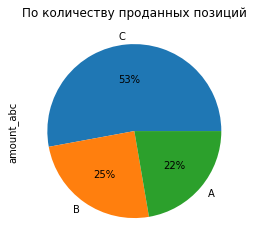

In [39]:
df['amount_abc'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('По количеству проданных позиций')

22% товаров принадлежат к группе А. 22% товаров обеспечивают 80% продаж.

Text(0.5, 1.0, 'По прибыли с позиции')

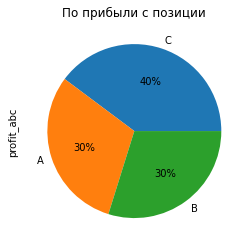

In [40]:
df['profit_abc'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('По прибыли с позиции')

30% товаров принадлежат к группе А. 30% товаров обеспечивают 80% прибыли с позиции.

Text(0.5, 1.0, 'По выручке')

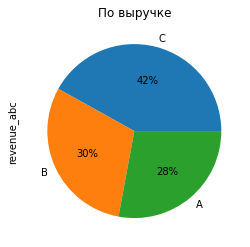

In [41]:
df['revenue_abc'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('По выручке')

28% товаров принадлежат к группе А. 28% товаров обеспечивают 80% выручки.

Соединим результаты ABC и XYZ в одну таблицу

In [42]:
sql = '''

---------------XYZ_ANALYSIS------------------------------

with xyz_t1 as -- сводная таблица с продажами товаров с разбивкой по неделям
( 
select dr_ndrugs as product,extract(week from dr_dat) as week_num, sum(dr_kol) as kol_per_week
from sales
group by dr_ndrugs, extract(week from dr_dat)
),
xyz_t2 as -- Исходя из коэффициента вариации (stddev_samp(kol_per_week) / avg(kol_per_week)) выводим группу, к которой относится продукт
(
select product,
case
  when stddev_samp(kol_per_week) / avg(kol_per_week) < 0.1 then 'X'
  when stddev_samp(kol_per_week) / avg(kol_per_week) < 0.25 then 'Y'
  else 'Z'
end as xyz_sales
from xyz_t1
group by product
having count(distinct week_num) >= 4
),

---------------ABC_ANALYSIS------------------------------

svod as -- Считаем Количество товара, Выручку и прибыль по каждому товару
(
  select dr_ndrugs as product, sum(dr_kol) as amount, 
  sum(dr_kol*(dr_croz - dr_czak) - dr_sdisc) as profit,
  sum(dr_kol*dr_croz - dr_sdisc) as revenue
  from sales
  group by dr_ndrugs
)

--В таблице ниже проводим многомерный ABC анализ.

/*
По количеству проданных позиций:
Считаем накопительную сумуу sum(amount) over (order by amount desc) для каждого продукта. 
Далее делим это значение на общую сумму по всей таблице sum(amount) over (). 
Затем сравниваем получившееся значение с 0.8, 0.95 и присваиваем соответствующую категорию данному товару.

По прибыли с позиции и по выручке проводим анализ аналогично.
*/


select s.product,

  case 
  when sum(amount) over (order by amount desc) / sum(amount) over () <= 0.8 then 'A'
  when sum(amount) over (order by amount desc) / sum(amount) over () <= 0.95 then 'B'
  else 'C'
  end as amount_abc,


  case 
  when sum(profit) over (order by profit desc) / sum(profit) over () <= 0.8 then 'A'
  when sum(profit) over (order by profit desc) / sum(profit) over () <= 0.95 then 'B'
  else 'C'
  end as profit_abc,

  case 
  when sum(revenue) over (order by revenue desc) / sum(revenue) over () <= 0.8 then 'A'
  when sum(revenue) over (order by revenue desc) / sum(revenue) over () <= 0.95 then 'B'
  else 'C'
  end as revenue_abc,

  xyz_t2.xyz_sales

from svod s
left join xyz_t2
  on s.product = xyz_t2.product
order by product
'''
t = select (sql)

In [43]:
t

,product,amount_abc,profit_abc,revenue_abc,xyz_sales
0,5-HTP НОЧНОЙ КОМПЛЕКС 515МГ. №30 ТАБ. П/О,C,B,C,None
1,5 ДНЕЙ КРЕМ Д/НОГ ОТ ПОТА И ЗАПАХА 30МЛ./35Г.,B,A,B,None
2,"5 ДНЕЙ СР-ВО Д/НОГ ОТ ПОТА И ЗАПАХА 1,5Г. №10 ...",A,A,B,Z
3,7 НОТ ЗДОРОВЬЯ БАДЯГА ФОРТЕ ГЕЛЬ П/ПЯТЕН П/УГР...,B,B,C,None
4,7 СЕМЬ ДНЕЙ МАСКА Д/ЛИЦА ПЯТНИЦА ЗАЖИГ. ПЕРЕД ...,C,C,C,None
...,...,...,...,...,...
6555,ЯНУМЕТ 1000МГ.+50МГ. №56 ТАБ. П/П/О,C,A,A,None
6556,ЯРИНА №21 ТАБ. П/П/О,B,A,A,Z
6557,ЯРИНА №63 (21Х3) ТАБ. П/П/О,B,A,A,None
6558,ЯРИНА ПЛЮС №28 ТАБ. П/П/О,C,A,A,None


<AxesSubplot:>

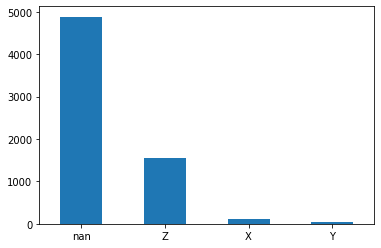

In [52]:
t['xyz_sales'].value_counts(dropna=False).plot(kind='bar',rot=0)

* Категория X - товары, на которые всегда стабильный спрос. Всегда должны быть на складе.     
* Категория Y - спрос на эти товары средний, но прогнозируемый. Закупать в большом количестве смысла нет.      
* Категория Z - спрос на данные товары достаточно низкий. Такие товары следует закпать только по необходимости.    

In [66]:
svod = t[~t['xyz_sales'].isna()].copy()

**Построим сводники и посмотрим на распределение товаров по группам:**

In [69]:
svod.pivot_table(index='xyz_sales', columns='amount_abc', values='product', aggfunc='nunique')

amount_abc,A,B,C
xyz_sales,,,
X,8.0,94.0,NaN
Y,31.0,NaN,NaN
Z,1250.0,281.0,15.0


In [70]:
svod.pivot_table(index='xyz_sales', columns='profit_abc', values='product', aggfunc='nunique')

profit_abc,A,B,C
xyz_sales,,,
X,61.0,31.0,10.0
Y,27.0,4.0,NaN
Z,1096.0,348.0,102.0


In [71]:
svod.pivot_table(index='xyz_sales', columns='revenue_abc', values='product', aggfunc='nunique')

revenue_abc,A,B,C
xyz_sales,,,
X,58,27,17
Y,24,6,1
Z,996,415,135


XA, YA, XB - самые лучшие товары. Если говорить о выручке (revenue_abc), то такие товары обеспечивают наибольшую выручку и меют наибольший спрос среди покупателей. Для прибыли и количества аналогичный вывод.

In [75]:
svod[(svod['revenue_abc'] == 'A') & (svod['xyz_sales'] == 'X')]

,product,amount_abc,profit_abc,revenue_abc,xyz_sales
412,АНГИОРУС 100МГ.+900МГ. №30 ТАБ. П/П/О /СИНТЕЗ/,B,A,A,X
426,АНТАРЕЙТ 800+40МГ. №24 ТАБ.ЖЕВ.,B,A,A,X
470,"АРИФАМ 5МГ.+1,5МГ. №30 ТАБ. МОДИФ.ВЫСВ. П/О",B,A,A,X
497,"АРТРАКАМ 1,5Г. №20 ПОР. Д/Р-РА Д/ПРИЕМА ВНУТРЬ...",B,A,A,X
500,АРТРА МСМ 1690МГ. №60 ТАБ. П/О ФЛ.,B,A,A,X
832,БЕТАГИСТИН 24МГ. №60 ТАБ. /ВЕРТЕКС/,B,B,A,X
1236,ВИД-КОМОД Р-Р Д/ГЛАЗ 10МЛ. КОНТ.,B,A,A,X
1362,ВОЛЬТАРЕН ПЛАСТЫРЬ ТРАНСДЕРМ. 30МГ/СУТКИ 100Х1...,B,A,A,X
1376,ГАБАПЕНТИН 300МГ. №50 КАПС. /ПИК-ФАРМА/,B,A,A,X
1637,ДАНТИНОРМ БЕБИ 1МЛ. №10 Р-Р Д/ВНУТР. Д/СНЯТ.ВО...,B,A,A,X
